# Assumptions and Snails

This dataset is about abalone snails.  Resources about the data can be found [here](https://archive.ics.uci.edu/ml/datasets/Abalone).

In [1]:
!pip install nb_black
%reload_ext nb_black

ModuleNotFoundError: No module named 'IPython.core.inputtransformer2'

In [3]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


cols = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole_Weight",
    "Shucked_Weight",
    "Visecra_Weight",
    "Shell_Weight",
    "Rings",
]
abalone = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1GwCnxFT4Sd6iZDj07kNNhEREr7OJQnGvtxd67b5AMio/export?format=csv",
    names=cols,
)

Get to know the data.  Our target variable is `'Rings'`.

In [4]:
abalone.head()

,Sex,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Visecra_Weight,Shell_Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


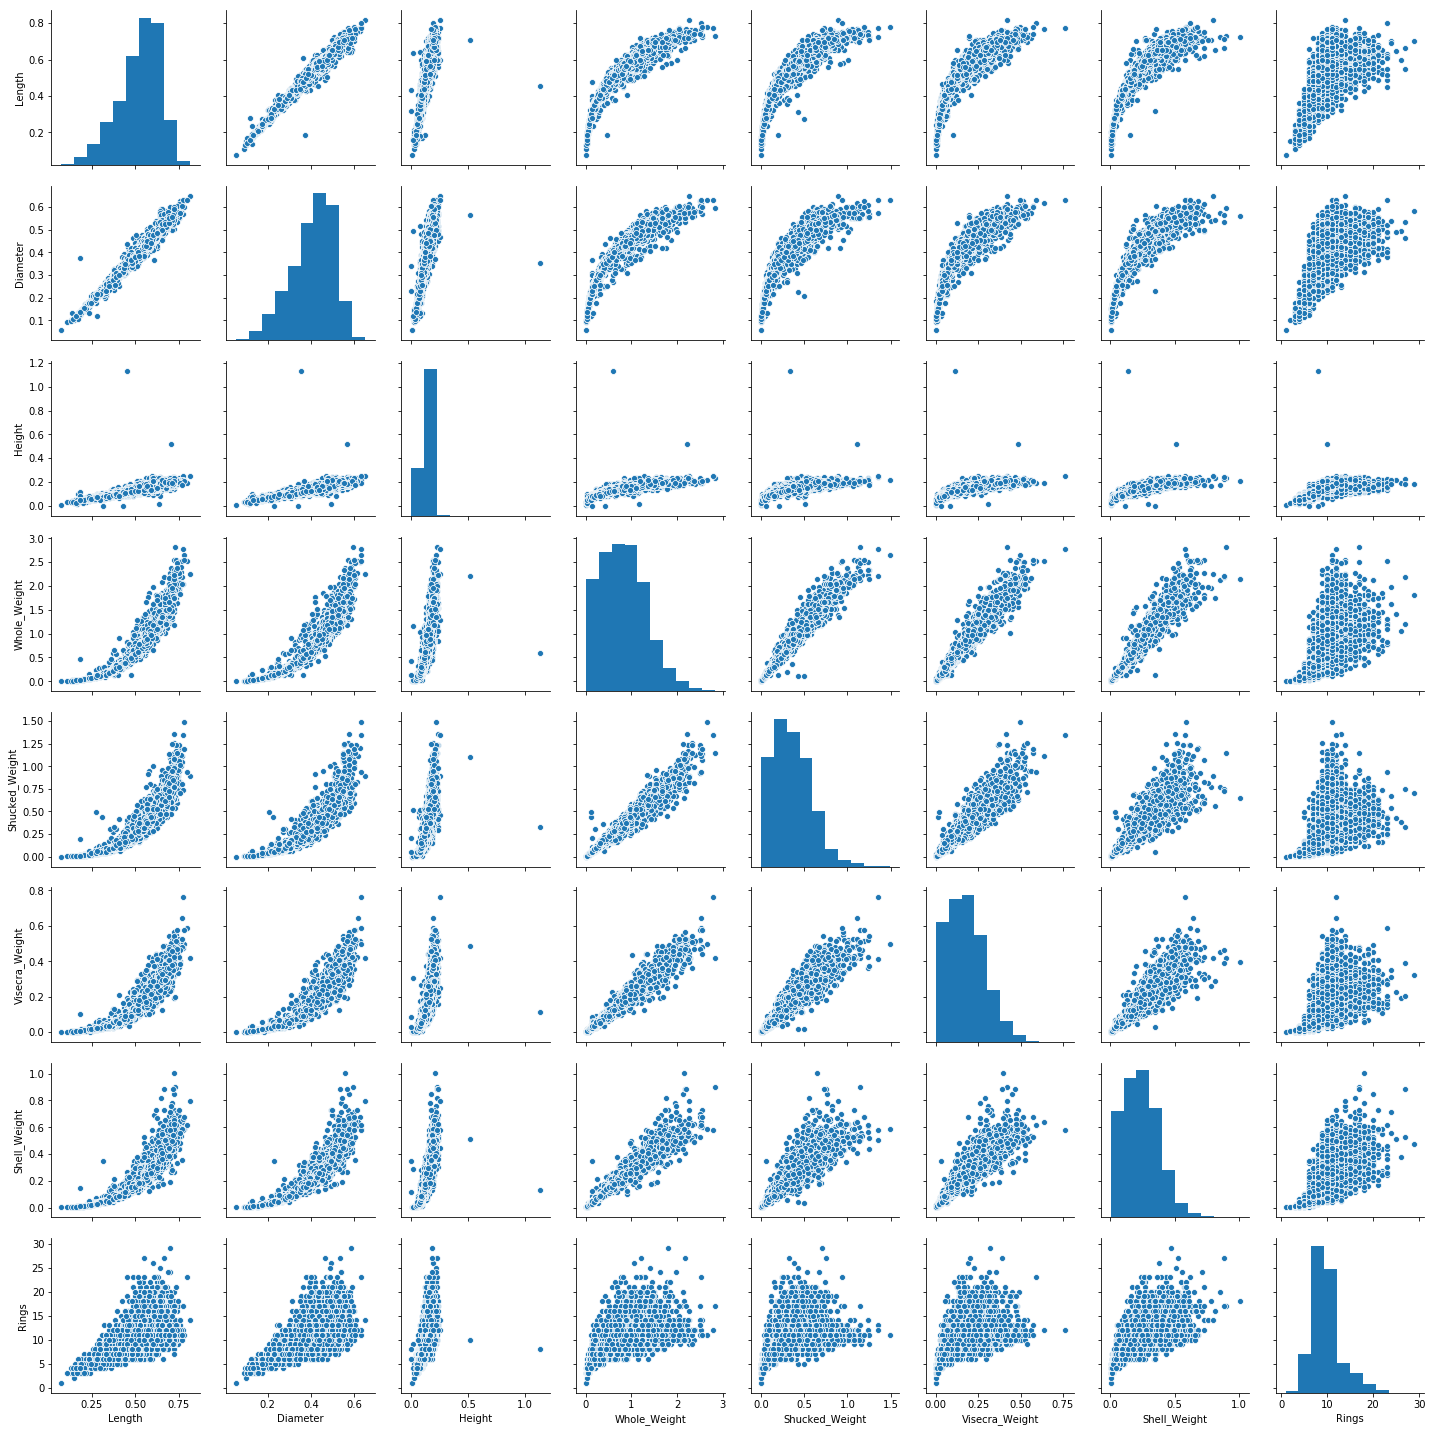

In [6]:
sns.pairplot(abalone)
plt.show()

## Linearity

If we want to model our data with a linear model, we're assuming that there's a linear relationship.

We can sort of play around with this one by doing transformations to our inputs.  For example we can easily model $y = x^2$ with a linear model by squaring $x$ before inputting it into our model and making the relationship linear.  Squaring is the goto example for this type of transformation to linearity, but remember some other transforms we've looked at like square root and log.

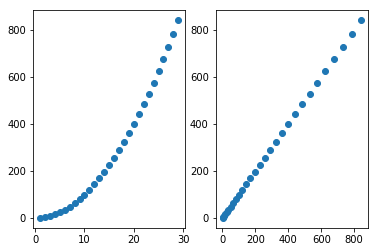

In [7]:
# (un)comment different transformations to learn the
# shape that these type relationships have in scatterplots
# fmt: off
def transform(x):
#     return np.sqrt(x)
#     return np.log(x)
    return x**2
# fmt: on


X = np.arange(1, 30)
y = transform(X)

fig, axes = plt.subplots(1, 2)
axes[0].scatter(X, y)
axes[1].scatter(transform(X), y)
plt.show()

Looking into our abalone snails dataset what linear relationships do we see?  Which ones do you think we could make linear with a transform?

## Error has a mean of 0

Nothing to add to what's in [the reading](https://courses.thinkful.com/dsbc-regression-problems-v1/checkpoint/3).  Just know that this is referring the theoritical error term that you see written out in formulas.  In practice our mistakes are more formally referred to as 'residuals', these residuals are essentially guaranteed to have a mean of 0 due to how the algorithms (like OLS) fit the model.

Mistakes in sample: Residual

Overall error in population: error


## Homoscedasticity

Big fancy hard to read word that means "same variance".  In short, we don't want our errors to have any pattern to them.  The whole reason we're modeling is to capture as many patterns and use these patterns to make accurate predictions.  If we have a pattern to our errors, we should find a way to include this pattern in the model.

Below we'll look at an example with `'Length'` and `'Rings'`.  Looking at the scatter plot between the 2 variables we see:
  1. They're positively correlated
      * The longer the snail the more rings; makes sense
  2. The longer the snail the more variation in ring count there is
      * This also makes some sense.  Short snails only have so much room to make rings, so they have a smaller range of outcomes; longer snails have more potential for diversity of ring count.
      
Number 2 should raise a red flag that we'll likely end up with heteroscedastic errors (aka our errors will get worse the longer the snail).  Let's prove this out.

Below we see that our model fits the data as best as it can.  By using transparency we can see that the line might be a little bit biased towards overpredicting (i.e. the most dense/opaque clumps of points are below the line).  

In [ ]:
X = abalone["Length"]
y = abalone["Rings"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Add a constant for the intercept
# This will work but throw a warning.. to silence the warning you can pass X.values instead
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_train)

lm_results = sm.OLS(y_train, X_train_const).fit()
y_pred = lm_results.predict(X_test_const)

plt.scatter(X_train, y_train, alpha=0.1)
plt.plot(X_train, y_pred, c="red")
plt.xlabel("Length")
plt.ylabel("Rings")
plt.show()

lm_results.summary()

Now let's look at some residual plots, which is where we actually diagnose problems with homoscedasticity.  We look at residuals because we'll typically be working in higher dimensions than 2d (which is the only reason we were able to spot this problem this early).

We'll create a random normal sample of residuals to compare our observed residuals against. 

In [ ]:
true_residuals = lm_results.resid
rand_norm_residuals = np.random.normal(0, 3, len(y_train))


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(X_train, rand_norm_residuals, alpha=0.2)
axes[0].axhline(0, c="red", alpha=0.5)
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Residual")
axes[0].set_title("What we want to see")

axes[1].scatter(X_train, true_residuals, alpha=0.2)
axes[1].axhline(0, c="red", alpha=0.5)
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Residual")
axes[1].set_title("What we actually see")
plt.show()

We can further prove this out with a formal test if we're not convinced.  The reading shows bartlett & levene tests for this.  These test are more generic tests of variance, and in the case of checking this assumption, they are pretty sensitive and will say you're violating the assumption with slight deviations.

I recommend something more directly designed for testing this assumption.  This is a good ole hypothesis test, so we'll get a null, alternative, and a p-value.

* $H_0$: Data is homoscedastic
* $H_a$: Data is heteroscedastic

In [ ]:
# null hypothesis: data is homoscedastic
_, p, _, _ = het_breuschpagan(true_residuals, X_train_const)
p

Ok... so we have a problem, we violated the homoscedasticiticity assumption. Now what... well as always, it depends.

Hopefully you're a domain expert on the data your modeling or your working with one.  Maybe there's a variable your snail scientist knows about that can lead to higher ring counts.  For example, maybe a snail's diet (like iron intake?) is a good predictor of rings and including some features about diet will capture this pattern of higher variation in longer snails.

An alternative is to try out a 'variance stabilizing transformation'.  Our whole issue is around variance so we might be able to take tackle this head on. This can might be done with `sklearn.preprocessing.power_transform()`.  In this case, it doesn't solve the issue, and is omitted.

## Multicolinearity

This is when you have redundancy in your predictors.  If you have highly redundant features (i.e. celsius and fahrenheit or dummy variables without dropping one) this is a really big issue for the model.  The model can't figure out which of the corelated variables to use.

For example, if you have salt and sugar unlabeled in the kitchen, and you asked people to make a recipe (without tasting), you'd expect people to mess up which is which.  They look similar (ie highly correlated), so people ended up using the wrong amounts of each one.  This is kind of similar to the model's issues with highly correlated variables, it doesn't know which to use and might use the wrong amount of each one (i.e. it doesn't know how to assign the right coefficient).  If the coefficients are 'unstable' we can say they have a high 'variance'.

This is how we can directly identify multicolinearity, by looking at the variance of the coeficients using the 'variance inflation factor'.  Variables with a high *VIF* are highly redundant of another variable (similar to correlations).

Note, correlations can also help identify this issue, VIF just gives us a single number per feature so theres less to theres numbers to have to look through.

> Variance inflation factors range from 1 upwards. The numerical value for VIF tells you (in decimal form) what percentage the variance (i.e. the standard error squared) is inflated for each coefficient. For example, a VIF of 1.9 tells you that the variance of a particular coefficient is 90% bigger than what you would expect if there was no multicollinearity — if there was no correlation with other predictors.
A rule of thumb for interpreting the variance inflation factor:
>
>  * 1 = not correlated.
>  * Between 1 and 5 = moderately correlated.
>  * Greater than 5 = highly correlated.
>
> Exactly how large a VIF has to be before it causes issues is a subject of debate. What is known is that the more your VIF increases, the less reliable your regression results are going to be. In general, a VIF above 10 indicates high correlation and is cause for concern. Some authors suggest a more conservative level of 2.5 or above.

Source: [statisticshowto](https://www.statisticshowto.com/variance-inflation-factor/)

In [ ]:
# You can copy/paste a VIF function from here:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5

#import warnings
#import statsmodels.api as sm
#from statsmodels.stats.outliers_influence import variance_inflation_factor


def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)
    
    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print('VIF results\n-------------------------------')
    print(pd.Series(vifs, index=x.columns))
    print('-------------------------------\n')

In [ ]:
# Manual calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = abalone[["Rings", "Shucked_Weight", "Height", "Diameter"]]
X = sm.add_constant(X)

vifs = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    vifs.append(vif)

pd.Series(vifs, index=X.columns)

If we forget to drop a level of a dummy variable we have perfectly redundant information in the inputs.

Given any 2 we can caluclate the other: `I = 1 - M + F`.

In [ ]:
X = pd.get_dummies(abalone["Sex"], drop_first=False)
X.head()

The VIF will reflect that theres a big issue of multicollinearity in this case.

In [ ]:
X = sm.add_constant(X)

vifs = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    vifs.append(vif)

pd.Series(vifs, index=X.columns)